In [291]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr?select=train.csv

In [292]:
import pandas as pd

train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle/Chest_Xray/mytrain.csv")
train_df['image_path'] = '/content/gdrive/MyDrive/kaggle/Chest_Xray/dataset/train/' + train_df['image_id'] + '.png' 
print(train_df.columns)
print(train_df.shape)
train_df.head()

Index(['Unnamed: 0', 'image_id', 'class_name', 'class_id', 'rad_id', 'x', 'y',
       'w', 'h', 'image_path'],
      dtype='object')
(36096, 10)


,Unnamed: 0,image_id,class_name,class_id,rad_id,x,y,w,h,image_path
0,0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340,602,473,200,/content/gdrive/MyDrive/kaggle/Chest_Xray/data...
1,1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,880,757,43,116,/content/gdrive/MyDrive/kaggle/Chest_Xray/data...
2,2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,880,757,43,116,/content/gdrive/MyDrive/kaggle/Chest_Xray/data...
3,3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,340,602,475,186,/content/gdrive/MyDrive/kaggle/Chest_Xray/data...
4,4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,339,575,481,197,/content/gdrive/MyDrive/kaggle/Chest_Xray/data...


In [293]:
# CLASS = train_df['class_name'].value_counts().index
# CLASS = list(CLASS)
CLASS = {0:'Aortic enlargement', 1:'Atelectasis', 2: 'Calcification', 3:'Cardiomegaly', 4:'Consolidation', 5:'ILD', 6:'Infiltration', 7:'Lung Opacity', 8:'Nodule/Mass', 9:'Other lesion', 10:'Pleural effusion', 11:'Pleural thickening', 12:'Pneumothorax', 13:'Pulmonary fibrosis'}
print(f'{CLASS}')
print( {len(CLASS)})


{0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD', 6: 'Infiltration', 7: 'Lung Opacity', 8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening', 12: 'Pneumothorax', 13: 'Pulmonary fibrosis'}
{14}


Model

In [294]:
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [295]:
cd /content/gdrive/MyDrive/kaggle/detr

/content/gdrive/MyDrive/kaggle/detr


In [296]:
!git clone https://github.com/facebookresearch/detr.git  

fatal: destination path 'detr' already exists and is not an empty directory.


In [297]:
! pip install albumentations==0.4.6

In [298]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################


#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [299]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [300]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [301]:
n_folds = 5
seed = 42
num_classes = len(CLASS)
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 100

In [302]:
seed_everything(seed)

In [303]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = train_df[['image_id', 'class_name']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby(['image_id','class_name']).count()

tmp = []
for i in range(len(df_folds.index)):
  tmp.append(df_folds.index[i][1])
len(tmp)

df_folds.loc[:, 'source'] = tmp
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [304]:
df_folds['stratify_group'].value_counts()

Aortic enlargement_0    3067
Cardiomegaly_0          2300
Pleural thickening_0    1980
Pulmonary fibrosis_0    1616
Lung Opacity_0          1321
Other lesion_0          1132
Pleural effusion_0      1032
Nodule/Mass_0            800
Infiltration_0           613
Calcification_0          450
ILD_0                    386
Consolidation_0          353
Atelectasis_0            186
Pneumothorax_0            96
Nodule/Mass_1             22
Nodule/Mass_2              2
Other lesion_1             2
Nodule/Mass_3              2
Calcification_1            2
Lung Opacity_1             1
Pulmonary fibrosis_1       1
Pleural thickening_1       1
Name: stratify_group, dtype: int64

In [305]:
df_folds['fold'].value_counts()

4    3073
3    3073
2    3073
1    3073
0    3073
Name: fold, dtype: int64

In [306]:
tmp = []
for i in range(len(df_folds.index)):
  tmp.append(df_folds.index[i][0])
len(tmp)

df_folds.loc[:,'id'] = tmp

In [307]:
df_folds

bbox_count  ...                                id
image_id                         class_name                      ...                                  
0005e8e3701dfb1dd93d53e2ff537b6e Consolidation                1  ...  0005e8e3701dfb1dd93d53e2ff537b6e
                                 Infiltration                 1  ...  0005e8e3701dfb1dd93d53e2ff537b6e
                                 Lung Opacity                 2  ...  0005e8e3701dfb1dd93d53e2ff537b6e
                                 Nodule/Mass                  1  ...  0005e8e3701dfb1dd93d53e2ff537b6e
0007d316f756b3fa0baea2ff514ce945 Aortic enlargement           2  ...  0007d316f756b3fa0baea2ff514ce945
...                                                         ...  ...                               ...
ffceb71a80efba3b83c88e11f4b9694b Pulmonary fibrosis           2  ...  ffceb71a80efba3b83c88e11f4b9694b
ffe6f9fe648a7ec29a50feb92d6c15a4 Aortic enlargement           1  ...  ffe6f9fe648a7ec29a50feb92d6c15a4
                                 Cardiomegaly                 3  ...  ffe6f9fe648a7ec29a50feb92d6c15a4
                                 Other lesion                 1  ...  ffe6f9fe648a7ec29a50feb92d6c15a4
ffeffc54594debf3716d6fcd2402a99f Aortic enlargement           3  ...  ffeffc54594debf3716d6fcd2402a99f

[15365 rows x 5 columns]

In [308]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      
                      # A.Resize(height=1024, width=1024, p=1),
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([
                      # A.Resize(height=1024, width=1024, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [325]:
DIR_TRAIN = '/content/gdrive/MyDrive/kaggle/Chest_Xray/dataset/train'

class XrayDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  torch.tensor(np.zeros(len(boxes), dtype=np.int32), dtype=torch.int64)
        #labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [326]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [327]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
"""
Train and eval functions used in main.py
"""
import math
import os
import sys
from typing import Iterable

import torch

import util.misc as utils
from datasets.coco_eval import CocoEvaluator
from datasets.panoptic_eval import PanopticEvaluator


def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 10

    for samples, targets in metric_logger.log_every(data_loader, print_freq, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled, **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, base_ds, device, output_dir):
    model.eval()
    criterion.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
    coco_evaluator = CocoEvaluator(base_ds, iou_types)
    # coco_evaluator.coco_eval[iou_types[0]].params.iouThrs = [0, 0.1, 0.5, 0.75]

    panoptic_evaluator = None
    if 'panoptic' in postprocessors.keys():
        panoptic_evaluator = PanopticEvaluator(
            data_loader.dataset.ann_file,
            data_loader.dataset.ann_folder,
            output_dir=os.path.join(output_dir, "panoptic_eval"),
        )

    for samples, targets in metric_logger.log_every(data_loader, 10, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {target['image_id'].item(): output for target, output in zip(targets, results)}
        if coco_evaluator is not None:
            coco_evaluator.update(res)

        if panoptic_evaluator is not None:
            res_pano = postprocessors["panoptic"](outputs, target_sizes, orig_target_sizes)
            for i, target in enumerate(targets):
                image_id = target["image_id"].item()
                file_name = f"{image_id:012d}.png"
                res_pano[i]["image_id"] = image_id
                res_pano[i]["file_name"] = file_name

            panoptic_evaluator.update(res_pano)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    if coco_evaluator is not None:
        coco_evaluator.synchronize_between_processes()
    if panoptic_evaluator is not None:
        panoptic_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    if coco_evaluator is not None:
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
    panoptic_res = None
    if panoptic_evaluator is not None:
        panoptic_res = panoptic_evaluator.summarize()
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}
    if coco_evaluator is not None:
        if 'bbox' in postprocessors.keys():
            stats['coco_eval_bbox'] = coco_evaluator.coco_eval['bbox'].stats.tolist()
        if 'segm' in postprocessors.keys():
            stats['coco_eval_masks'] = coco_evaluator.coco_eval['segm'].stats.tolist()
    if panoptic_res is not None:
        stats['PQ_all'] = panoptic_res["All"]
        stats['PQ_th'] = panoptic_res["Things"]
        stats['PQ_st'] = panoptic_res["Stuff"]
    return stats, coco_evaluator


In [328]:
matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [336]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        ##
        losses.requires_grad = True
        ##
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [337]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [338]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [339]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    # print(f'df_train: {df_train}')
    # print(f'df_valid: {df_valid}')
    
    train_dataset = XrayDataset(
    image_ids=df_train['id'],
    dataframe=train_df,
    transforms=get_train_transforms()
    )

    print(f'dataset {train_dataset}')
    
    valid_dataset = XrayDataset(
    image_ids=df_valid['id'],
    dataframe=train_df,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'/content/gdrive/MyDrive/kaggle/Chest_Xray/mymodel/detr_best_{fold}.pth')

In [340]:
run(fold=0)

dataset <__main__.XrayDataset object at 0x7ff3002cde80>


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master



|EPOCH 1| TRAIN_LOSS 3.996788002410025| VALID_LOSS 4.0581401533894725|
Best model found for Fold 0 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 3.9988966997986735| VALID_LOSS 4.058140168871199|



|EPOCH 3| TRAIN_LOSS 4.002729539833987| VALID_LOSS 4.0581401595821625|


KeyboardInterrupt: ignored

In [323]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = XrayDataset(image_ids=df_valid['id'],
                                 dataframe=train_df,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)

    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images

    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
     
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]

    sample = images[0].permute(1,2,0).cpu().numpy()
    predict = sample.copy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    print(f'outputs {len(outputs[0]["pred_logits"][0][0])}') # 14
    print(f'outputs {outputs[0]["pred_logits"][0][0]}') 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    

    #  
    count = 0
    for box in boxes:
        count += 1    
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
    print(f'count {count}')

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    print(f'check {len(outputs[0]["pred_logits"][0])}')
    
    # labels = []
    # for i in range(len(outputs[0]["pred_logits"][0])):
    #   label_idx = outputs[0]["pred_logits"][0][i].argmax()
    #   label = CLASS[label_idx]
    #   labels.append(label)


    print(f'oboxes {oboxes}')
    print(f'len(oboxes){len(oboxes)}')
    print(f'prob {prob}')
    print(f'len(prob) {len(prob)}')

    count = 0
    for box,p in zip(oboxes,prob):
        # print(f'box {box}')
        # print(f'p {p}')

        if p >0:
            color = (0,220,0)
            cv2.rectangle(predict,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
            # cv2.putText(predict, labels[count],
            #             (box[0], box[1]-3), cv2.FONT_HERSHEY_COMPLEX, 1, 
            #             (0, 255, 255) , 2)
        count += 1
    
    ax[0].set_axis_off()
    ax[0].imshow(sample)
    ax[1].set_axis_off()
    ax[1].imshow(predict)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


outputs 14
outputs tensor([-0.4467,  0.5692,  0.1287,  0.7288, -0.4758,  0.1255, -1.2182, -0.0984,
         0.7720,  0.1292, -0.8908, -0.5667, -1.0567,  0.8925])
count 5
check 100
oboxes [array([  8, 918,  17, 219], dtype=int32), array([743, 664, 373, 701], dtype=int32), array([ 512,  984, 1023,   80], dtype=int32), array([860,  18, 315,  37], dtype=int32), array([ 511,  414, 1023,  829], dtype=int32), array([571, 433, 902, 863], dtype=int32), array([647, 971, 498, 104], dtype=int32), array([214, 993, 314,  60], dtype=int32), array([ 73,   6, 146,  12], dtype=int32), array([ 511,  409, 1023,  818], dtype=int32), array([884, 972, 179, 104], dtype=int32), array([985, 887,  76, 273], dtype=int32), array([ 511,  424, 1023,  844], dtype=int32), array([941, 958, 164, 131], dtype=int32), array([763, 973, 285, 101], dtype=int32), array([ 511,  409, 1023,  819], dtype=int32), array([14, 18, 29, 37], dtype=int32), array([940,   7, 161,  15], dtype=int32), array([913, 963, 221, 120], dtype=int32)

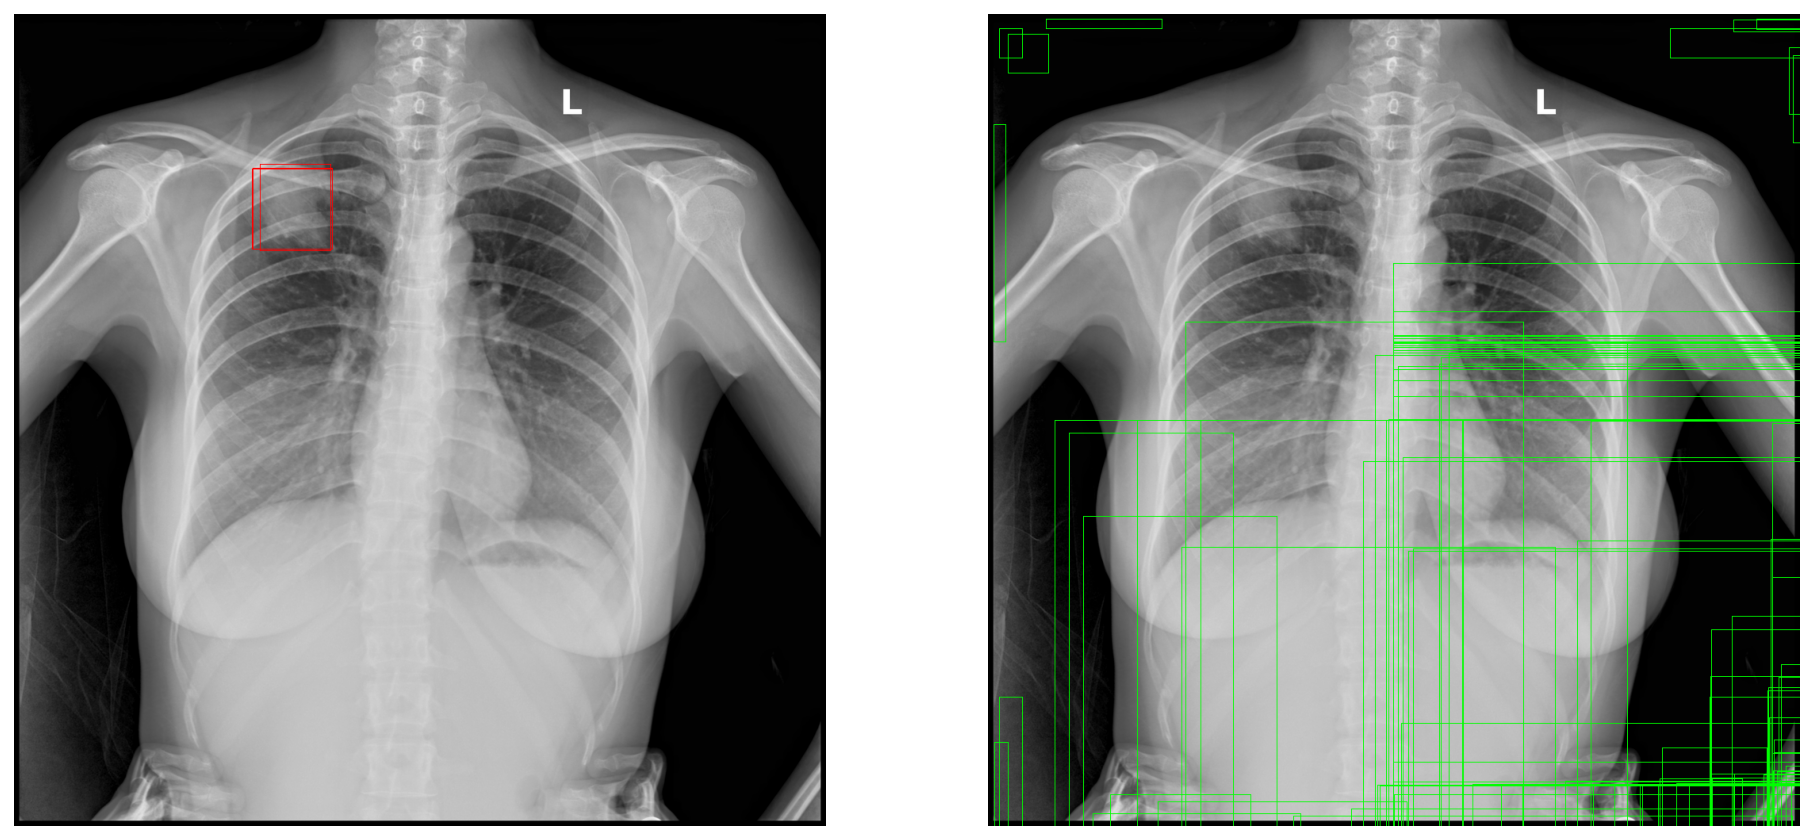

In [324]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/kaggle/Chest_Xray/mymodel/detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 1],model=model,device=torch.device('cuda'))

F12 -> console탭 -> 하단 입력창

# 실행
var timer = setInterval(function(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}, 60*1000);
timer;

# 종료
clearInterval(timer);
timer;